# Clipping Rio Grande Riparian Zones

In [9]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import json
import requests
import time
from requests.auth import HTTPBasicAuth
from osgeo import gdal
import subprocess
import datetime
import xarray as xr
import rioxarray as rxr
import pandas as pd
import geopandas as gp
import pathlib
from planet import Session, DataClient, OrdersClient
import geojsonio
import shutil
import rasterio.plot as show
import contextily as cx
print("packages loaded.")

packages loaded.


EPSG:4326


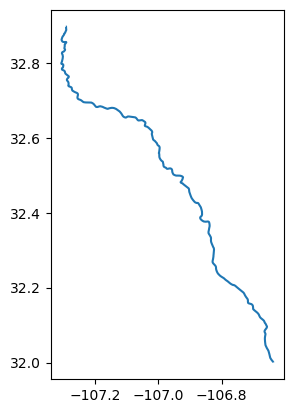

In [8]:
# Read in the River Shapefile
filename = "Better_flowline.shp"
filepath = os.path.join('Data/Shapefiles/', filename)
river = gp.read_file(filepath)
river.plot()
print(river.crs)

Visualize with a basemap to make sure it's in the right place

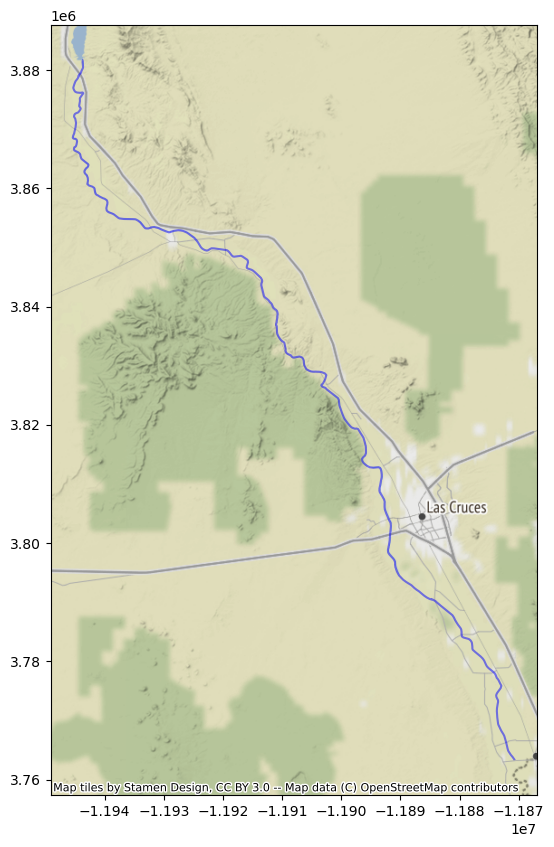

In [12]:
river_wm = river.to_crs(3857)
ax = river_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor="b")
cx.add_basemap(ax)

The cooridnate system is  +init=epsg:3857 +type=crs
Total area (km^2):  0    7.619191
Name: area, dtype: float64


/Users/danielletadych/opt/miniconda3/envs/planet/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


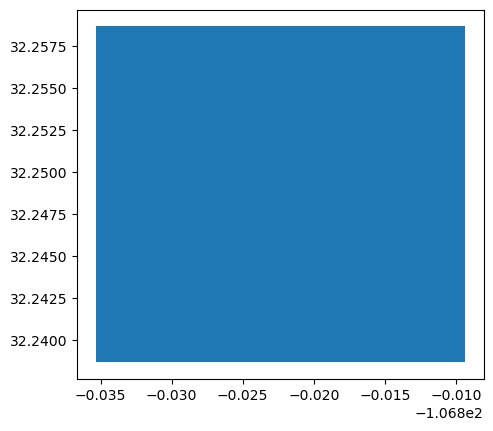

In [24]:
site_name = 'MES_48R'
longitude = -106.8223400
latitude = 32.2486900

# Buffer
buffer_lat = 0.01
buffer_lon = 0.013

wells= pd.DataFrame(
    {
        "Site_Name":[site_name],
        "Latitude":[latitude],
        "Longitude":[longitude]
    }
)

wells_gdf = gp.GeoDataFrame(wells,geometry=gp.points_from_xy(wells.Longitude,wells.Latitude,crs="4326"))
wells_gdf = wells_gdf.to_crs("3857")

study_area = {"type":"MultiPolygon",
              "coordinates":[[
        [
            [(longitude+buffer_lon),(latitude-buffer_lat)], #left, bottom
            [(longitude+buffer_lon),(latitude+buffer_lat)], #left, top
            [(longitude-buffer_lon),(latitude+buffer_lat)], #right, top
            [(longitude-buffer_lon),(latitude-buffer_lat)], #right, bottom
            [(longitude+buffer_lon),(latitude-buffer_lat)] #left, bottom
         ]
         ]]}

# site_name = 'test'
with open('AOI/'+site_name+'.json', 'w', encoding='utf-8') as f:
    json.dump(study_area, f, ensure_ascii=False, indent=4)

gdf = gp.read_file('AOI/'+site_name+'.json')
gdf.plot()

tost = gdf.copy()
tost= tost.to_crs({'init': 'epsg:3857'})
print("The cooridnate system is ",tost.crs)
tost["area"] = tost['geometry'].area/ 10**6
print("Total area (km^2): ",tost['area'])

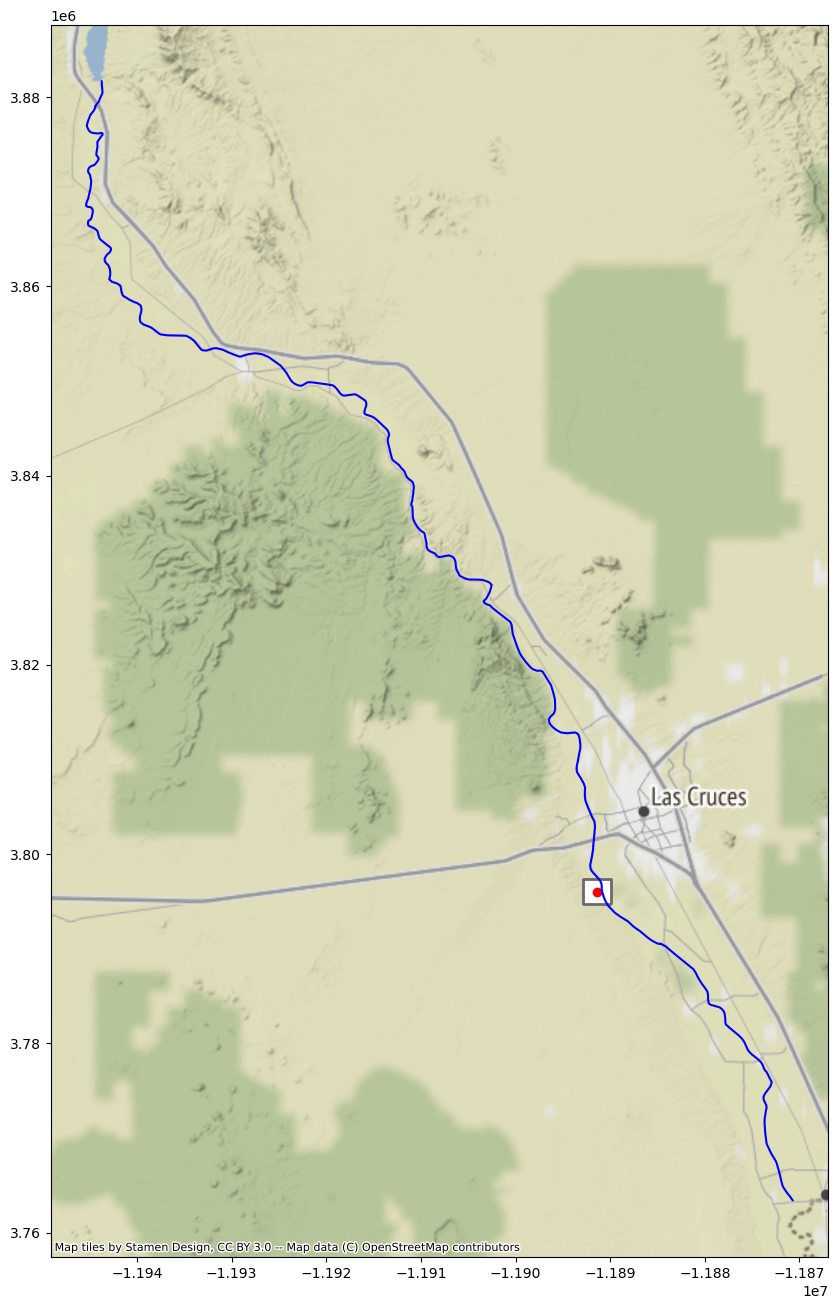

In [25]:
# ax = tost.plot(figsize=(10, 10), alpha=0.5, edgecolor="b")
# river_wm.plot()

fig, ax = plt.subplots(figsize=(16, 16))

tost.plot(ax=ax, color='#ffffff', edgecolor='#6a6a6a', linewidth=2)
wells_gdf.plot(ax=ax,color='r')
river_wm.plot(ax=ax, color='b')
cx.add_basemap(ax)

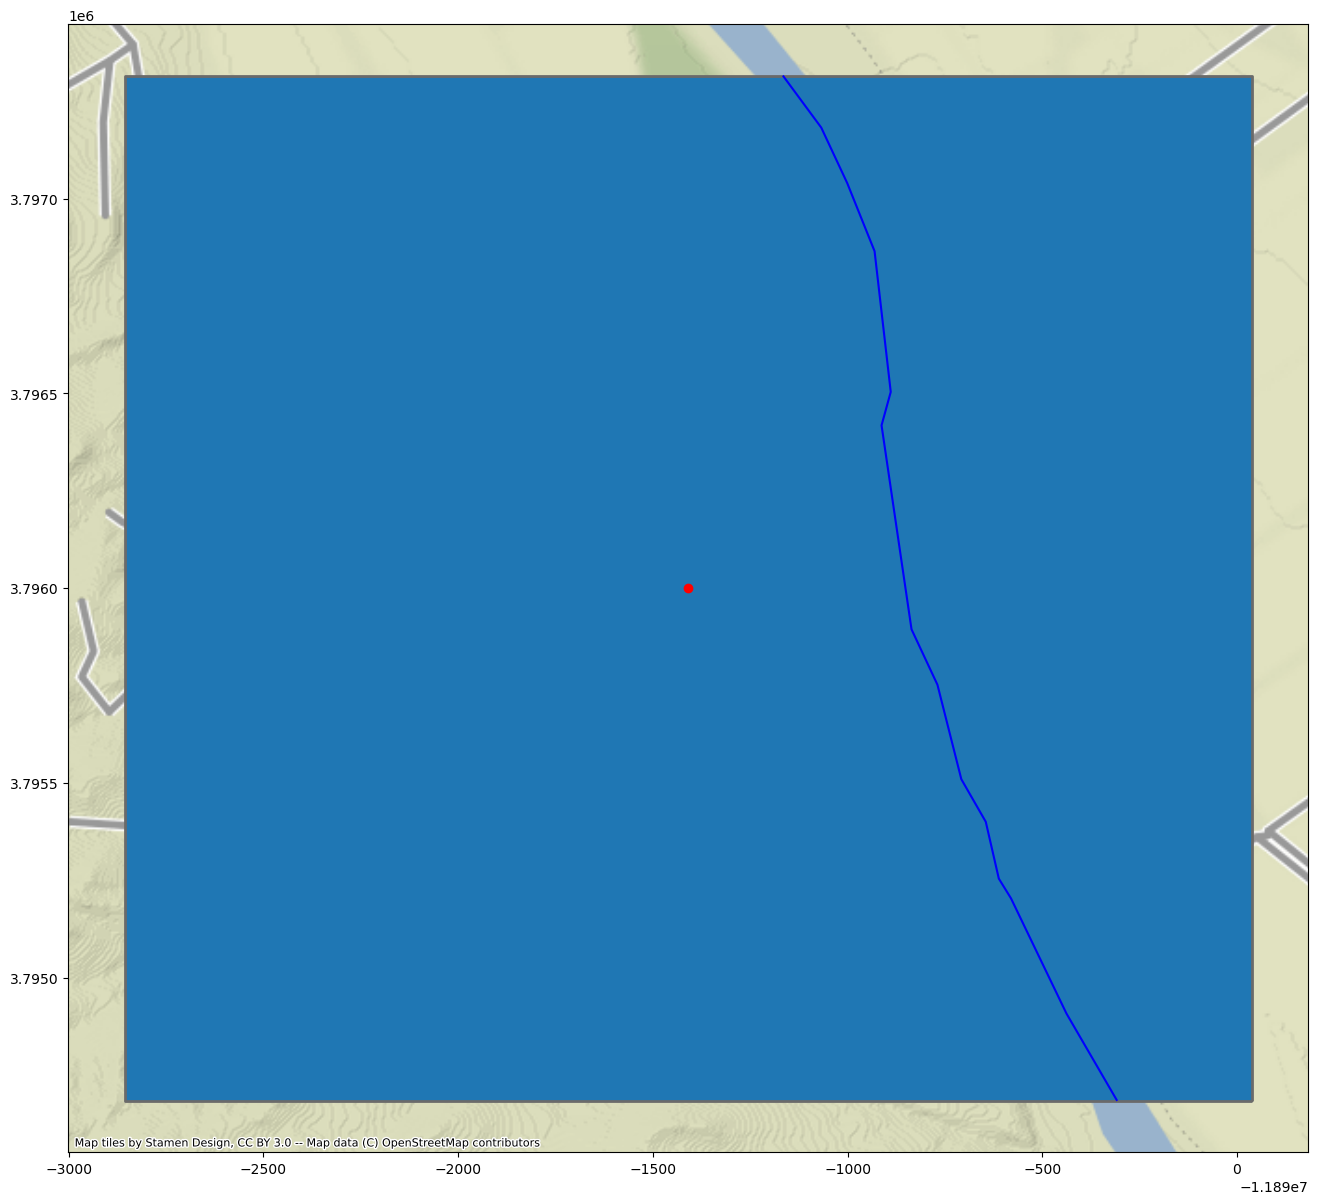

In [30]:
river_clip = gp.clip(river_wm,tost)
fig, ax = plt.subplots(figsize=(16, 16))

tost.plot(ax=ax,edgecolor='#6a6a6a', linewidth=2)
wells_gdf.plot(ax=ax,color='r')
river_clip.plot(ax=ax, color='b')
cx.add_basemap(ax)

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_26807/895688233.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


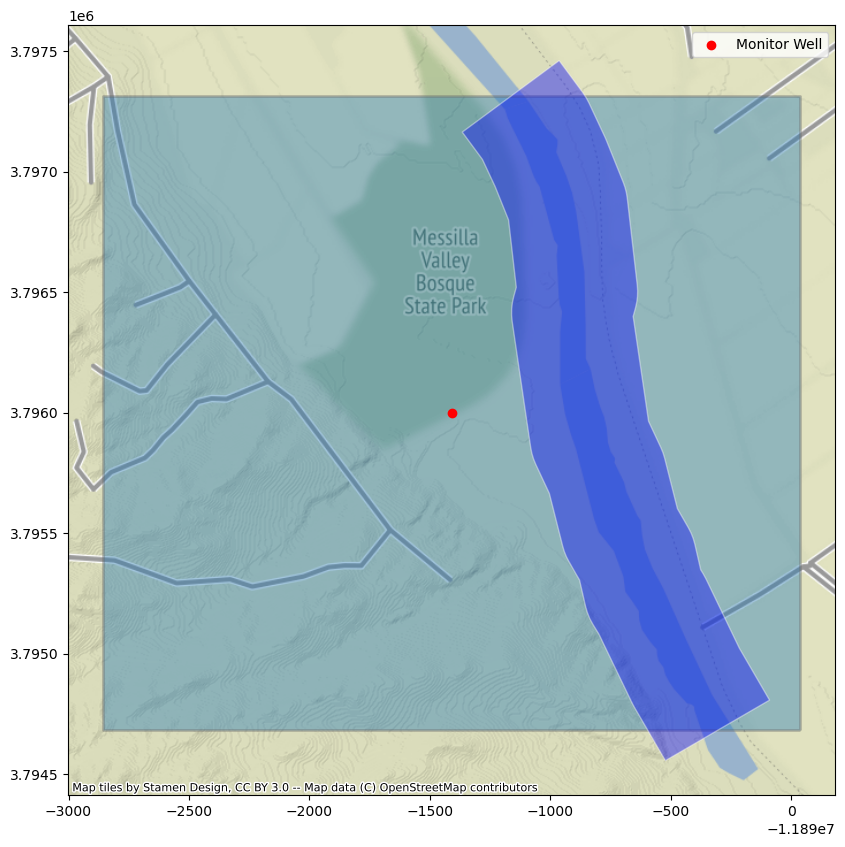

In [41]:
river_buffer = river_clip.buffer(250,cap_style=2)

fig, ax = plt.subplots(figsize=(10, 10))

tost.plot(ax=ax,edgecolor='#6a6a6a', alpha = 0.4, linewidth=2)
wells_gdf.plot(ax=ax,color='r',label="Monitor Well")
river_buffer.plot(ax=ax, color='b',alpha = 0.4,edgecolor='#FFFFFF',label="AOI")
ax.legend()
cx.add_basemap(ax)


In [42]:
river_buffer.to_file("AOI/"+site_name+"_riverbuffer.json", driver="GeoJSON")  

In [43]:
with open('dataframe.geojson' , 'w') as file:
    file.write(river_buffer.to_json())